In [25]:
import pandas as pd 

import psana as ps
import numpy as np
import math 
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial as npply
import sys
import os
import h5py
import scipy.stats as st
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter as gf
from sklearn.utils import resample
sys.path.append('/reg/data/ana16/rix/rixlv1519/results/LCLS_LV15_2021/TestCode/EarlyScience/AnalyzeH5/')
from chemRIXSAnalysis import *
from ChemRIXSClasses import *
from filterTools import *
sys.path.append('/reg/data/ana16/rix/rixlv1519/results/LCLS_LV15_2021/Functions/')
from Functions import *
from Load_Scans import *
from raw_data_class import RawData as RDC
from pro_data_class import ProData as PDC


font = {'size'   : 16}
mpl.rc('font', **font)
%matplotlib widget
cmap = plt.cm.get_cmap('terrain').reversed()

In [54]:
exp = 'rixlv1519'
small_data_folder = '/reg/data/ana01/rix/%s/hdf5/smalldata/' % exp #changeme
scans = [43,44]
raw = h5py.File(small_data_folder+'%s_Run%04d.h5' % (exp,43))
print(list(raw.keys()))


['Sums', 'UserDataCfg', 'andor_dir', 'ebeam', 'epicsAll', 'gmd', 'hsd', 'lightStatus', 'mono_encoder', 'rix_fim0', 'rix_fim0_raw', 'rix_fim1', 'rix_fim1_raw', 'rix_fim2', 'rix_fim2_raw', 'timestamp', 'timing', 'xgmd']


In [34]:
raw_datas = []
for scan in scans:
    raw_data = load_scans_2(small_data_folder,exp,scan)
    
    
    I0_intensities_fim0, I0_specs_fim0, baselines_fim0 = \
    process_fim(raw_data.fim0_raw,np.arange(0,8),np.arange(0,50),np.arange(105,115))
    
    I0_intensities_fim1, I0_specs_fim1, baselines_fim1 = \
    process_fim(raw_data.fim1_raw,np.arange(0,8),np.arange(0,50),np.arange(105,115))
    
    
    intensities_fim2, I0_specs_fim2, baselines_fim2 = \
    process_fim(raw_data.fim1_raw,np.arange(0,8),np.arange(200,250),np.arange(50,130))
        
#     intensities_fim2=process_fim_2(raw_data.fim2_raw,np.arange(0,8))
    
    andor_dir_intensities, andor_dir_specs, baseline_andor_dir = \
    process_andor(raw_data.andor_dir_raw,np.arange(500,800),np.arange(900,1250))
    
    raw_data.changeValue(I0_intensities_fim0=I0_intensities_fim0,
                        I0_specs_fim0=I0_specs_fim0,
                        baselines_fim0=baselines_fim0,
                        I0_intensities_fim1=I0_intensities_fim1,
                        I0_specs_fim1=I0_specs_fim1,
                        baselines_fim1=baselines_fim1,
                        intensities_fim2=intensities_fim2,
                        andor_dir_intensities=andor_dir_intensities,
                        andor_dir_specs=andor_dir_specs,
                        baseline_andor_dir=baseline_andor_dir)
    
    
    raw_datas = raw_datas + [raw_data]
print(raw_datas[0].getKeys())

loading fim0
loading fim1
loading andor
loading fim2
loading fim0
loading fim1
loading andor
loading fim2
dict_keys(['xgmd', 'gmd', 'energy_raw', 'mono_encoder', 'pitch_raw', 'horz_raw', 'evrs', 'lxt', 'laser', 'fim0_raw', 'fim1_raw', 'andor_dir_raw', 'fim2_raw', 'I0_intensities_fim0', 'I0_specs_fim0', 'baselines_fim0', 'I0_intensities_fim1', 'I0_specs_fim1', 'baselines_fim1', 'intensities_fim2', 'andor_dir_intensities', 'andor_dir_specs', 'baseline_andor_dir'])


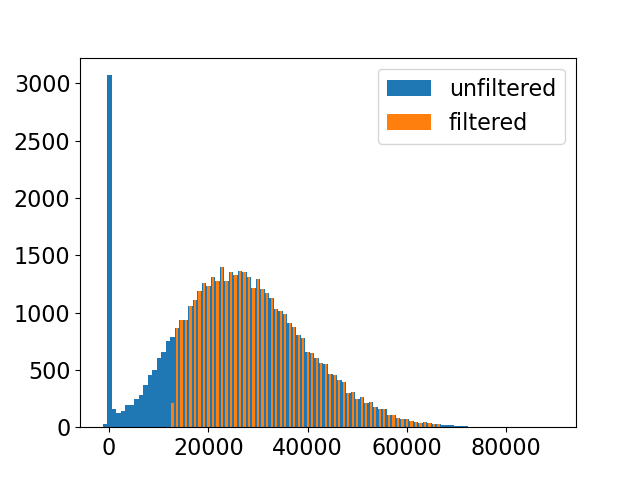

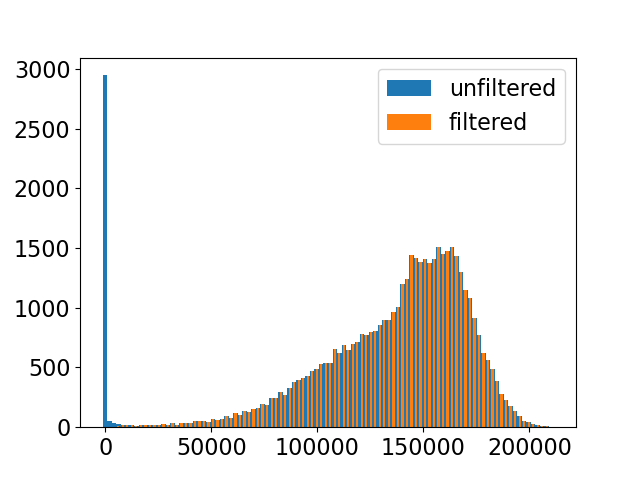

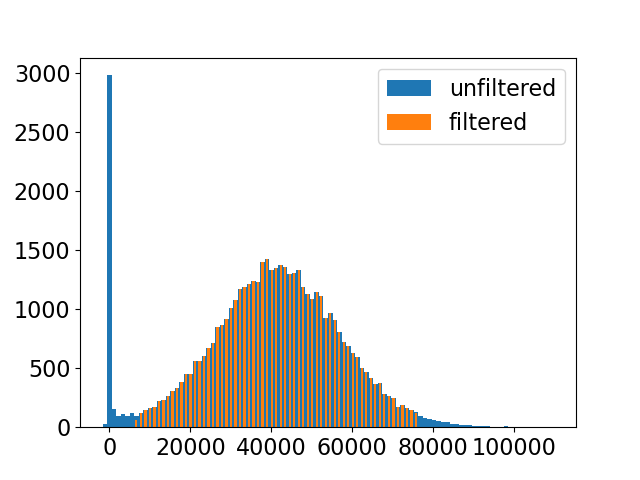

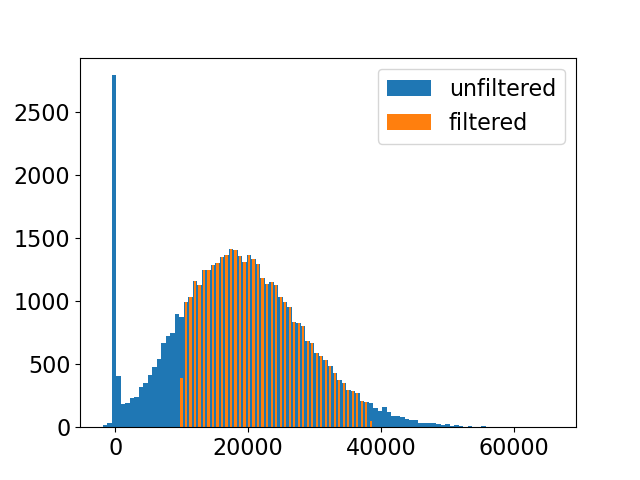

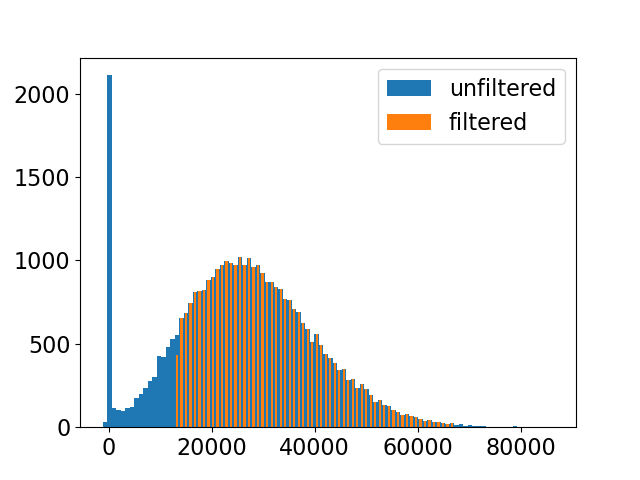

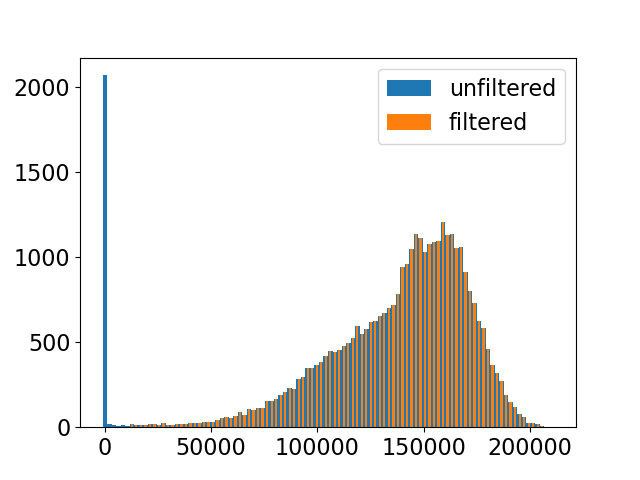

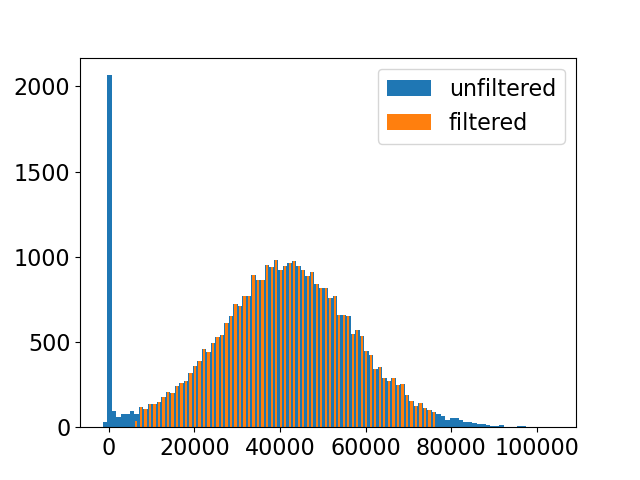

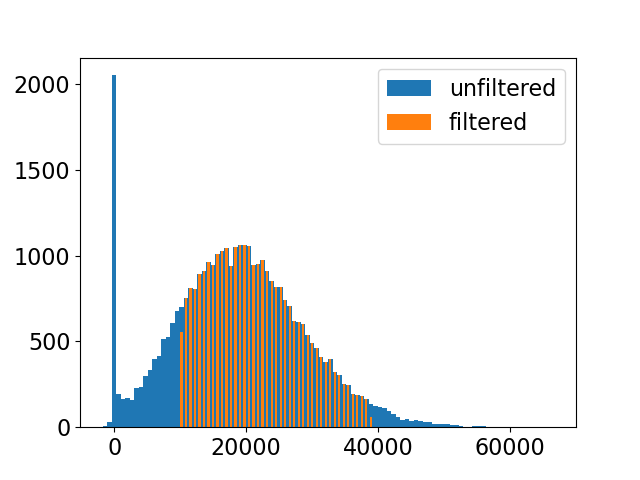

In [35]:
plt.close('all')
filter_params = []
for raw in raw_datas:
    filter_param = PDC()
    
    B_condition_1 = bounds_filter(raw.I0_intensities_fim1[4,:],[[13000,'None'],[3]],True) 
    B_condition_2 = bounds_filter(raw.I0_intensities_fim1[5,:],[[5000,'None'],[3]],True) 
    B_condition_3 = bounds_filter(raw.I0_intensities_fim1[6,:],[[6500,'None'],[2]],True) 
    B_condition_4 = bounds_filter(raw.I0_intensities_fim1[7,:],[[10000,'None'],[2]],True) 

    # raw.I0_intensities_fim0[4,:] is I0 intensities from fim0 channel 4


    bounds_condition = B_condition_2# & B_condition_2 & B_condition_3 & B_condition_4

    L_condition_1 = lin_filter(raw.I0_intensities_fim1[5,:], raw.andor_dir_intensities,[0.05,False],False)


    linearity_condition = L_condition_1
    condition = bounds_condition# & linearity_condition
    
    filter_param.changeValue(condition=condition)
    filter_params = filter_params + [filter_param]
    


In [44]:
scan_type = 'mono'
# scan_type = 'time'

pro_datas = []
for i in range(0,len(raw_datas)):
    pro_data = PDC()
    pumped = raw_datas[i].laser==1
    unpumped = raw_datas[i].laser==0
    condition = filter_params[i].condition
    
#     norm_by = np.square(np.mean(raw_datas[i].I0_intensities_fim1[4:7,:],0))
    norm_by = np.square(raw_datas[i].I0_intensities_fim1[5,:])

    
    if scan_type is 'mono':

        n_bins = 100
        mono_encoder_ev = np.squeeze(mono_calib(raw_datas[i].energy_raw,raw_datas[i].mono_encoder))
        
#         x_vals = np.squeeze(raw_datas[i].mono_encoder)#mono_encoder_ev
        x_vals = mono_encoder_ev

        y_vals = raw_datas[i].andor_dir_intensities
#         y_vals = raw_datas[i].intensities_fim2[0,:]
#         y_vals = np.sum(raw_datas[i].andor_dir_specs,1)
#         y_vals = norm_by
        
        ##### pumped #####
        energy,intensity_raw_pumped = \
        mono_spectrum(x_vals[pumped],n_bins,y_vals[pumped])
        
        energy,intensity_filtered_pumped = \
        mono_spectrum(x_vals[condition&pumped],n_bins,y_vals[condition&pumped])
        
        energy,intensity_norm_filtered_pumped = \
        mono_spectrum(x_vals[condition&pumped],n_bins,y_vals[condition&pumped]/norm_by[condition&pumped])
        
        ##### unpumped #####
        energy,intensity_raw_unpumped = \
        mono_spectrum(x_vals[unpumped],n_bins,y_vals[unpumped])
        
        energy,intensity_filtered_unpumped = \
        mono_spectrum(x_vals[condition&unpumped],n_bins,y_vals[condition&unpumped])
        
        energy,intensity_norm_filtered_unpumped = \
        mono_spectrum(x_vals[condition&unpumped],n_bins,y_vals[condition&unpumped]/norm_by[condition&unpumped])

        
        pro_data.changeValue(energy=energy,
                             intensity_raw_pumped = intensity_raw_pumped,
                             intensity_filtered_pumped = intensity_filtered_pumped,
                             intensity_norm_filtered_pumped = intensity_norm_filtered_pumped,
                             intensity_raw_unpumped = intensity_raw_unpumped,
                             intensity_filtered_unpumped = intensity_filtered_unpumped,
                             intensity_norm_filtered_unpumped = intensity_norm_filtered_unpumped)
        
        pro_datas = pro_datas + [pro_data]
        
    if scan_type is 'time':
        
        x_vals = raw_datas[i].lxt
        
        y_vals = raw_datas[i].andor_dir_intensities
        
        #pumped
        d_bins_raw, andor_intensities_time_raw = time_scan(x_vals,y_vals)
        
        d_bins_filt, andor_intensities_time_filt = time_scan(x_vals[condition],y_vals[condition])
        
        andor_intensities_time_norm_filt = \
        time_scan(x_vals[condition&unpumped],y_vals[condition&unpumped]/norm_by[condition&unpumped])[1]
        
        #unpumped
        andor_intensities_time_raw_pumped = time_scan(x_vals[pumped],y_vals[pumped])[1]
        
        andor_intensities_time_filt_pumped = time_scan(x_vals[condition&pumped],y_vals[condition&pumped])[1]
        
        andor_intensities_time_norm_filt_pumped = \
        time_scan(x_vals[condition&pumped],y_vals[condition&pumped]/norm_by[condition&pumped])[1]
        
        pro_data.changeValue(d_bins_raw=d_bins_raw,
                             andor_intensities_time_raw=andor_intensities_time_raw,
                             andor_intensities_time_filt=andor_intensities_time_filt,
                             d_bins_filt=d_bins_filt,
                             andor_intensities_time_norm_filt = andor_intensities_time_norm_filt,
                             andor_intensities_time_raw_pumped = andor_intensities_time_raw_pumped,
                             andor_intensities_time_filt_pumped = andor_intensities_time_filt_pumped,
                             andor_intensities_time_norm_filt_pumped =andor_intensities_time_norm_filt_pumped
                            )
        
        pro_datas = pro_datas + [pro_data]
        

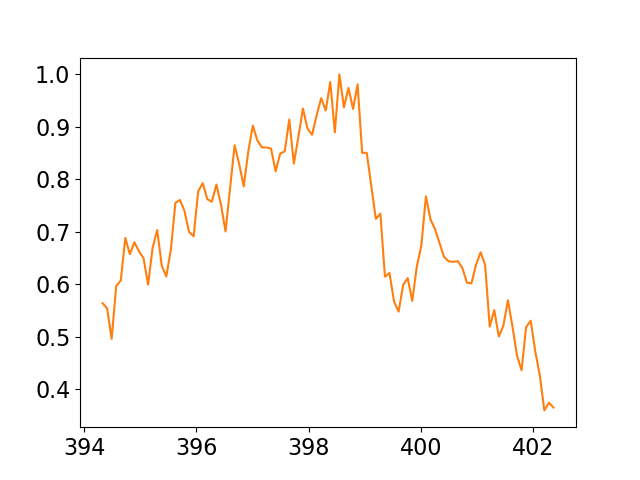

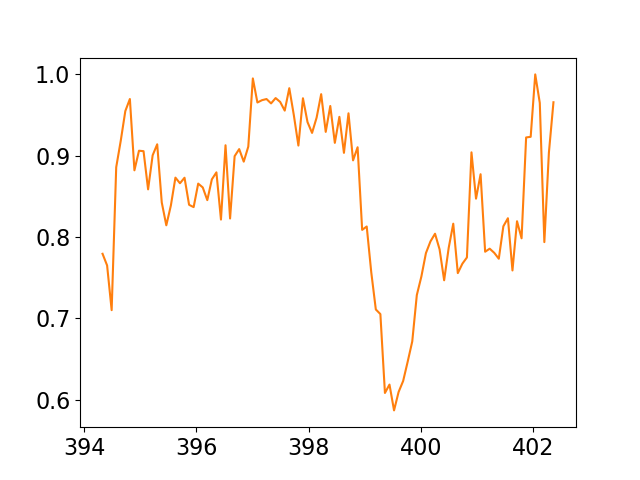

In [45]:
# plt.close('all')
# plt.figure()
# plt.plot(pro_datas[1].energy,pro_datas[1].intensity_raw_pumped)
# plt.plot(pro_datas[1].energy,pro_datas[1].intensity_filtered_pumped)
# plt.show()

plt.figure(10)
plt.plot(pro_datas[0].energy,pro_datas[0].intensity_raw_pumped/np.max(pro_datas[0].intensity_raw_pumped))
plt.plot(pro_datas[1].energy,pro_datas[1].intensity_raw_pumped/np.max(pro_datas[1].intensity_raw_pumped))
plt.show()

plt.figure(11)
plt.plot(pro_datas[0].energy,pro_datas[0].intensity_norm_filtered_pumped/np.max(pro_datas[0].intensity_norm_filtered_pumped))
plt.plot(pro_datas[1].energy,pro_datas[1].intensity_norm_filtered_pumped/np.max(pro_datas[1].intensity_norm_filtered_pumped))
# plt.legend(('4','5','6','7'))
plt.show()



# plt.figure(11)
# plt.plot(np.mean(raw_datas[0].fim1_raw[:,7,:],0))
# # plt.show()
# # raw_datas[0].fim1_raw[:,5,:].shape
# plt.legend(('4','5','6','7'))
# plt.show()
# raw_datas[i].mono_encoder.shape

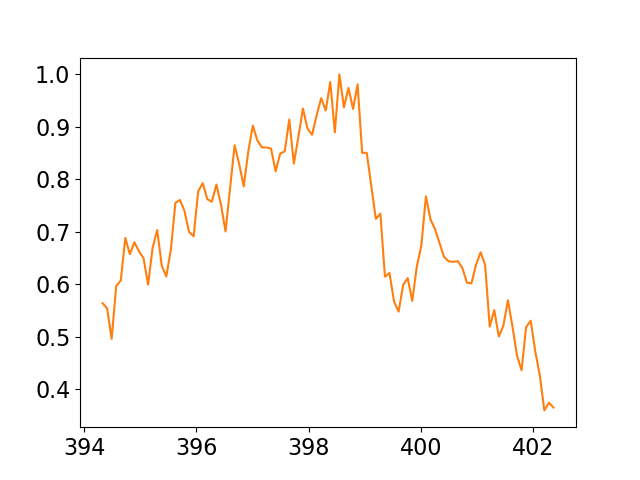

In [46]:
# plt.close('all')
plt.figure(10)
plt.plot(pro_datas[0].energy,pro_datas[0].intensity_raw_pumped/np.max(pro_datas[0].intensity_raw_pumped))
plt.show()

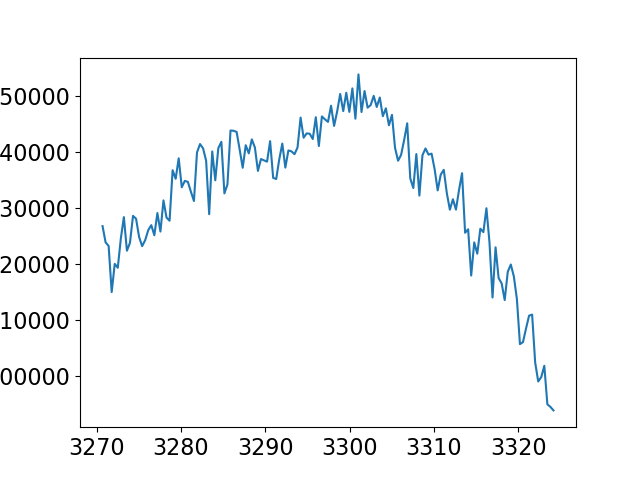

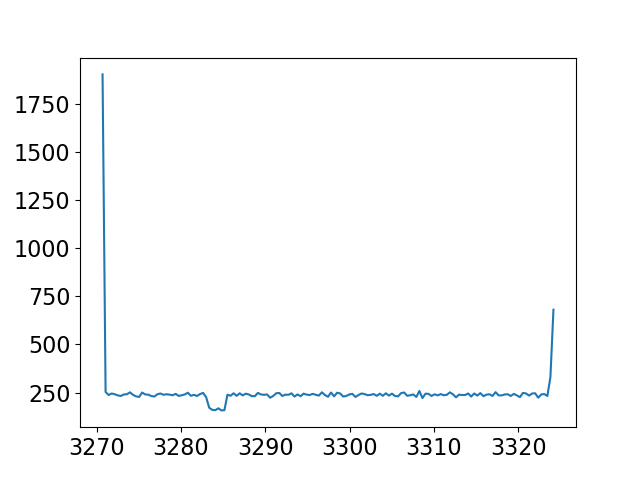

In [47]:
plt.close('all')
data = raw_datas[1]
cond = filter_params[1].condition
norm_by = raw_datas[1].I0_intensities_fim1[5,:]
y_value = norm_by#data.andor_dir_intensities/norm_by
# y_value = np.mean(data.I0_intensities_fim0[4:7,:],0)
x_value = data.mono_encoder
n_bins = 150
bins,intensity,shots = energy_binning(x_value,y_value,n_bins)
shots_per_bin = np.asarray([i.shape[0] for i in shots])
plt.figure()
plt.plot(bins[0:-1],intensity)

plt.figure()
# _, bins, _ = plt.hist(shots)#, 100, label='unfiltered')
plt.plot(bins[0:-1],shots_per_bin)
